## dataload

In [1]:
import mlflow
import mlflow.lightgbm
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename
os.environ["LOGNAME"]='cwj'
SEED=13

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'lgbm_rolling_mean.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid = valid.drop('answerCode',axis=1)
y_valid = valid[['answerCode']]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1845539, 42), (1845539, 1), (1974, 42), (1974, 1))

## Hyper Parameter 설정

In [24]:
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

In [25]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'rolling3_mean_acc', 'rolling5_mean_acc',
       'rolling7_mean_acc', 'rolling10_mean_acc'],
      dtype='object')

In [ ]:
## 기존? 8156

## rolling3_mean_acc 추가

In [325]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling3_mean_acc'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM rolling3_mean_acc 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model_cwj_test = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )

    
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model_cwj_test_run_id=run.info.run_id
    post_slack("done")
    print(f"{model_cwj_test_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model_cwj_test, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/04 Sun)[LGBM rolling3_mean_acc 추가] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling3_mean_acc')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19714
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.184523
[200]	valid_0's binary_logloss: 0.178232
[300]	valid_0's binary_logloss: 0.176357
Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.176188
VALID AUC : 0.8908649335900853 ACC : 0.8019250253292807

model_cwj_test_run_id='46409dd9659d474e94cf1581c63cfb58'
writing prediction : output/12_04_Sun_LGBM_rolling3_mean_acc

array([1.58017486e-05, 3.19126017e-02, 4.96546823e-05, 8.46016959e-02,
       4.87063099e-05, 1.02585230e-02, 1.21496241e-04, 2.58281251e-05,
       4.57661751e-05, 2.34588521e-01, 3.16079769e-05, 6.10262677e-02,
       4.59462729e-02, 2.51905680e-05, 5.31627743e-05, 8.64212869e-02,
       4.27777233e-05, 1.34004569e-02, 5.16475626e-02, 2.53958700e-05,
       8.02237830e-05, 3.05805799e-03, 1.19693540e-05, 2.70173498e-05,
       1.83953096e-05, 2.09763509e-01, 4.59388268e-02, 8.87094165e-02,
       8.07747436e-05, 1.47928486e-02, 4.61492690e-05, 1.23590674e-02,
       8.64868074e-05, 2.90688230e-05, 4.66098766e-05, 2.90916400e-01,
       5.46492067e-03, 1.11378506e-01, 3.93814958e-05, 3.30476072e-05,
       4.45917189e-05, 4.33424168e-05, 6.15402984e-05, 4.66066790e-05,
       4.28881726e-02, 1.00056744e-01, 2.87398687e-05, 3.75658492e-05,
       2.42672316e-05, 1.21466925e-05, 3.08396468e-02, 2.36147859e-05,
       5.28718334e-05, 4.01554792e-05, 2.22664367e-03, 2.38960346e-01,
      

In [26]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling3_mean_acc'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM rolling3_mean_acc 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model3 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )

    
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model3_run_id=run.info.run_id
    post_slack("done")
    print(f"{model3_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model3, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/03 Sat)[LGBM rolling3_mean_acc 추가] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling3_mean_acc')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19714
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.243814
[200]	valid_0's binary_logloss: 0.200274
[300]	valid_0's binary_logloss: 0.189833
[400]	valid_0's binary_logloss: 0.185175
[500]	valid_0's binary_logloss: 0.182399
[600]	valid_0's binary_logloss: 0.18029
[700]	valid_0's binary_logloss: 0.178973
[800]	valid_0's binary_logloss: 0.178308
[900]	valid_0's binary_logloss: 0.177594
[1000

In [ ]:
pd.read_csv('output/12_03_Sat_LGBM_rolling3_mean_acc_추가_피처_29개.csv')

In [33]:
test2 = test[test.answerCode != -1]

test3 = test2[test2.userID != test2.userID.shift(-1)]

valid2 = test3.drop('answerCode',axis=1)
y_valid2 = test3[['answerCode']]

val_preds = model3.predict(valid2[FEATS])
acc = accuracy_score(y_valid2, np.where(val_preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid2, val_preds)
auc

0.9903586607462894

In [17]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.6558
run_id = 'd82837fb4a2e4050acb5c6625d2bea56'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: d82837fb4a2e4050acb5c6625d2bea56


### 과적합 방지

In [36]:
# Hyper parameter 설정
params = {
    "max_depth": 8,  # 8,
    "min_data_in_leaf": 300,
    "feature_fraction": 0.6,  # 0.8,
    "bagging_fraction": 0.75,
    "max_cat_group": 64,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.01,  # 0.01,
    "bagging_freq": 5,
    "seed": 42,
    "max_bin": 50,
    "num_leaves": 80,  # 40,
#     "metric": "auc",
}
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling3_mean_acc'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM rolling3_mean_acc 추가 과적합 방지 HP추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model31 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=10,
        num_boost_round=600,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=10,
    )

    preds = model31.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model31_run_id=run.info.run_id
    post_slack("done")
    print(f"{model31_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model31, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/03 Sat)[LGBM rolling3_mean_acc 추가 과적합 방지 HP추가] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling3_mean_acc')

[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16966
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.694703
[20]	valid_0's binary_logloss: 0.638002
[30]	valid_0's binary_logloss: 0.602962
[40]	valid_0's binary_logloss: 0.56371
[50]	valid_0's binary_logloss: 0.529287
[60]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[580]	valid_0's binary_logloss: 0.213845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[590]	valid_0's binary_logloss: 0.212821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's binary_logloss: 0.212016
Did not meet early stopping. Best iteration is:
[600]	valid_0's binary_logloss: 0.212016
VALID AUC : 0.97569495877154 ACC : 0.9037487335359676

model31_run_id='9999b15d85f8409fb14a282f82f912ac'
writing 

## rolling5_mean_acc 추가

In [13]:
## 
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling5_mean_acc'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM rolling5_mean_acc 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model4 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )

    preds = model4.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model4_run_id=run.info.run_id
    post_slack("done")
    print(f"{model4_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model4, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/03 Sat)[LGBM rolling5_mean_acc 추가] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling5_mean_acc')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19720
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.232511
[200]	valid_0's binary_logloss: 0.194782
[300]	valid_0's binary_logloss: 0.183521
[400]	valid_0's binary_logloss: 0.177875
[500]	valid_0's binary_logloss: 0.172564
[600]	valid_0's binary_logloss: 0.169783
[700]	valid_0's binary_logloss: 0.167977
[800]	valid_0's binary_logloss: 0.16617
[900]	valid_0's binary_logloss: 0.165393
[1000

In [16]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.7059
run_id = '68fa5f491b0b43ad8779fd38231af90f'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 68fa5f491b0b43ad8779fd38231af90f


## rolling7_mean_acc 추가

In [15]:
## 
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling7_mean_acc'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM rolling7_mean_acc 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model5 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=10000,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )

    preds = model5.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model5_run_id=run.info.run_id
    post_slack("done")
    print(f"{model5_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model5, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/03 Sat)[LGBM rolling7_mean_acc 추가] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling7_mean_acc')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19728
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.37503
[200]	valid_0's binary_logloss: 0.336682
[300]	valid_0's binary_logloss: 0.319336
[400]	valid_0's binary_logloss: 0.312439
[500]	valid_0's binary_logloss: 0.304893
[600]	valid_0's binary_logloss: 0.300395
[700]	valid_0's binary_logloss: 0.295513
[800]	valid_0's binary_logloss: 0.29145
[900]	valid_0's binary_logloss: 0.288579
[1000]

KeyboardInterrupt: 

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=
run_id = model_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## rolling10_mean_acc 추가

In [37]:
## 
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
#     "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling10_mean_acc'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM rolling10_mean_acc 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model6 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )

    preds = model6.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model6_run_id=run.info.run_id
    post_slack("done")
    print(f"{model6_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model6, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/03 Sat)[LGBM rolling10_mean_acc 추가] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling10_mean_acc')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19742
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.442755
[200]	valid_0's binary_logloss: 0.431905
[300]	valid_0's binary_logloss: 0.422125
[400]	valid_0's binary_logloss: 0.416556
[500]	valid_0's binary_logloss: 0.414231
[600]	valid_0's binary_logloss: 0.412097
[700]	valid_0's binary_logloss: 0.410296
[800]	valid_0's binary_logloss: 0.409633
[900]	valid_0's binary_logloss: 0.408887
[100

In [38]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.7733
run_id = '38b2fbd739b8453697e7665ca5a5d3db'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 38b2fbd739b8453697e7665ca5a5d3db


### 과적합 방지

In [57]:
## 
# Hyper parameter 설정
params = {
    "max_depth": 8,  # 8,
    "min_data_in_leaf": 1000,
    "feature_fraction": 0.6,  # 0.8,
    "bagging_fraction": 0.75,
    "max_cat_group": 64,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    "bagging_freq": 5,
    "seed": 42,
    "max_bin": 50,
    "num_leaves": 80,  # 40,
    "metric": "auc",
}
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling10_mean_acc'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM rolling10_mean_acc 과적합 방지] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model61 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=10,
        num_boost_round=300,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=20,
    )

    preds = model61.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model61_run_id=run.info.run_id
    post_slack("done")
    print(f"{model61_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model61, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/03 Sat)[LGBM rolling10_mean_acc 과적합 방지] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling10_mean_acc')

[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16994
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.831937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's auc: 0.83567
[30]	valid_0's auc: 0.836517
[40]	valid_0's auc: 0.838625
[LightGBM] [Warning] N

In [58]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.7823
run_id = '4178f8e68c914412a5c0e58cfe1779f5'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 4178f8e68c914412a5c0e58cfe1779f5


### 과적합 방지 2

In [59]:
## 
# Hyper parameter 설정
params = {
    "max_depth": 8,  # 8,
    "min_data_in_leaf": 1000,
    "feature_fraction": 0.6,  # 0.8,
    "bagging_fraction": 0.75,
    "max_cat_group": 64,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    "bagging_freq": 5,
    "seed": 42,
    "max_bin": 50,
    "num_leaves": 80,  # 40,
    "metric": "auc",
}
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling10_mean_acc'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM rolling10_mean_acc 과적합 방지2] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model62 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=10,
        num_boost_round=300,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=10,
    )

    preds = model62.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model62_run_id=run.info.run_id
    post_slack("done")
    print(f"{model62_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model62, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/04 Sun)[LGBM rolling10_mean_acc 과적합 방지2] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling10_mean_acc')

[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16994
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.831937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's auc: 0.83567
[30]	valid_0's auc: 0.836517
Early stopping, best iteration is:
[25]	valid_0's a

In [60]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.7705
run_id = '4f2990c891904c3ebfc297cabbdc248c'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 4f2990c891904c3ebfc297cabbdc248c


## val set을 test set 으로

In [39]:
train = df[df.kind=='train']
test = df[df.kind=='test'] # 테스트 데이터
test_df = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
valid = test_df[test_df.userID != test_df.userID.shift(-1)]

train.shape, valid.shape, test.shape

x_train2 = train.drop('answerCode',axis=1)
y_train2 = train[['answerCode']]

x_valid2 = valid.drop('answerCode',axis=1)
y_valid2 = valid[['answerCode']]
x_train2.shape, y_train2.shape, x_valid2.shape, y_valid2.shape

((2266586, 43), (744, 43), (260114, 43))

((2266586, 42), (2266586, 1), (744, 42), (744, 1))

In [42]:
## 
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
#     "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling10_mean_acc'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM rolling10_mean_acc 추가 valset2test] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train2[FEATS], y_train2)
lgb_x_valid = lgb.Dataset(x_valid2[FEATS], y_valid2)

with mlflow.start_run(run_name=title, description=desc) as run:
    model7 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )

    preds = model7.predict(x_valid2[FEATS])
    acc = accuracy_score(y_valid2, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid2, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model7_run_id=run.info.run_id
    post_slack("done")
    print(f"{model7_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model7, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/03 Sat)[LGBM rolling10_mean_acc 추가 valset2test] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling10_mean_acc')

[LightGBM] [Info] Number of positive: 1483205, number of negative: 783381
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20761
[LightGBM] [Info] Number of data points in the train set: 2266586, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654378 -> initscore=0.638341
[LightGBM] [Info] Start training from score 0.638341
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.419525
[200]	valid_0's binary_logloss: 0.408126
[300]	valid_0's binary_logloss: 0.400858
[400]	valid_0's binary_logloss: 0.397037
[500]	valid_0's binary_logloss: 0.393534
[600]	valid_0's binary_logloss: 0.392678
[700]	valid_0's binary_logloss: 0.39038
[800]	valid_0's binary_logloss: 0.389615
[900]	valid_0's binary_logloss: 0.388225
[1000

In [52]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.7649
run_id = '59025bf22784476f80412cac8c3356b5'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 59025bf22784476f80412cac8c3356b5


In [48]:
test_df.drop('answerCode',axis=1)
test_df[['answerCode']]

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,user_correct_answer,...,big_category_cumconut,big_category_answer,big_category_user_cum_acc,mid_category_cumconut,mid_category_answer,mid_category_user_cum_acc,rolling3_mean_acc,rolling5_mean_acc,rolling7_mean_acc,rolling10_mean_acc
1954,3,A050023001,A050000023,2020-01-09 10:56:31,2626,test,3,4235,804,NaN,...,0,0.0,0.000000,0,0.0,0.000000,1.000000,1.000000,1.000000,1.000000
1955,3,A050023002,A050000023,2020-01-09 10:56:57,2626,test,3,4236,804,1.0,...,1,1.0,1.000000,1,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
1956,3,A050023003,A050000023,2020-01-09 10:58:31,2625,test,3,4237,804,2.0,...,2,2.0,1.000000,2,2.0,1.000000,0.666667,0.666667,0.666667,0.666667
1957,3,A050023004,A050000023,2020-01-09 10:58:36,2625,test,3,4238,804,2.0,...,3,2.0,0.666667,3,2.0,0.666667,0.333333,0.500000,0.500000,0.500000
1958,3,A050023006,A050000023,2020-01-09 10:58:43,2623,test,3,4240,804,2.0,...,4,2.0,0.500000,4,2.0,0.500000,0.000000,0.400000,0.400000,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526670,7439,A040197006,A040000197,2020-08-21 07:39:45,2132,test,7439,4083,780,7.0,...,10,7.0,0.700000,5,3.0,0.600000,0.333333,0.600000,0.571429,0.700000
2526671,7439,A040130001,A040000130,2020-10-14 23:07:23,8832,test,7439,3728,713,8.0,...,11,8.0,0.727273,0,0.0,0.000000,0.333333,0.400000,0.571429,0.600000
2526672,7439,A040130002,A040000130,2020-10-14 23:07:41,8832,test,7439,3729,713,8.0,...,12,8.0,0.666667,1,0.0,0.000000,0.666667,0.400000,0.571429,0.600000
2526673,7439,A040130003,A040000130,2020-10-14 23:08:02,8244,test,7439,3730,713,9.0,...,13,9.0,0.692308,2,1.0,0.500000,0.666667,0.600000,0.571429,0.600000


,answerCode
1954,1
1955,1
1956,0
1957,0
1958,0
...,...
2526670,1
2526671,0
2526672,1
2526673,1


In [49]:
all_preds = model7.predict(test_df.drop('answerCode',axis=1)[FEATS])

In [51]:
roc_auc_score(test_df[['answerCode']], all_preds)

0.900552548365294

## train / valid / valid_test로 나눠보기

In [61]:
train_df = df[df.kind=='train']
train3, valid3 = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split

x_train3 = train3.drop('answerCode',axis=1)
y_train3 = train3[['answerCode']]

x_valid3 = valid3.drop('answerCode',axis=1)
y_valid3 = valid3[['answerCode']]
x_train3.shape, y_train3.shape, x_valid3.shape, y_valid3.shape

((1586169, 42), (1586169, 1), (1974, 42), (1974, 1))

In [327]:
## 
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
#     "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling10_mean_acc'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM rolling10_mean_acc train/valid/valid_test로 나누기] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train3[FEATS], y_train3)
lgb_x_valid = lgb.Dataset(x_valid3[FEATS], y_valid3)

with mlflow.start_run(run_name=title, description=desc) as run:
    model8 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )

    preds = model8.predict(x_valid3[FEATS])
    acc = accuracy_score(y_valid3, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid3, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model8_run_id=run.info.run_id
    post_slack("done")
    print(f"{model8_run_id=}")
    file_name = title2filename(title)
    model8_test_preds = lgbm_predict(test, model8, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/04 Sun)[LGBM rolling10_mean_acc train/valid/valid_test로 나누기] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling10_mean_acc')

[LightGBM] [Info] Number of positive: 1037893, number of negative: 548276
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19135
[LightGBM] [Info] Number of data points in the train set: 1586169, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654339 -> initscore=0.638169
[LightGBM] [Info] Start training from score 0.638169
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.441895
[200]	valid_0's binary_logloss: 0.428785
[300]	valid_0's binary_logloss: 0.420066
[400]	valid_0's binary_logloss: 0.413885
[500]	valid_0's binary_logloss: 0.412047
[600]	valid_0's binary_logloss: 0.410569
[700]	valid_0's binary_logloss: 0.409375
[800]	valid_0's binary_logloss: 0.408325
[900]	valid_0's binary_logloss: 0.40832
[1000]	valid_0's binary_logloss: 0.407947
[1100]	valid_0's binary_log

In [177]:
max(re_preds)

0.7867256676700772

In [87]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.7641
run_id = '72e018dc1033413684dfe65dacc89905'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 72e018dc1033413684dfe65dacc89905


## 결과 시각화

### 마지막 제외 테스트셋 전체

In [81]:
all_preds = model8.predict(test_df.drop('answerCode',axis=1)[FEATS])
roc_auc_score(test_df[['answerCode']], all_preds)
# 전체 AUC는 0.898

0.8980559230180039

In [130]:
test_df.reset_index(drop=True, inplace=True)

In [128]:
test_df.shape

(259370, 43)

In [127]:
len(all_preds)

259370

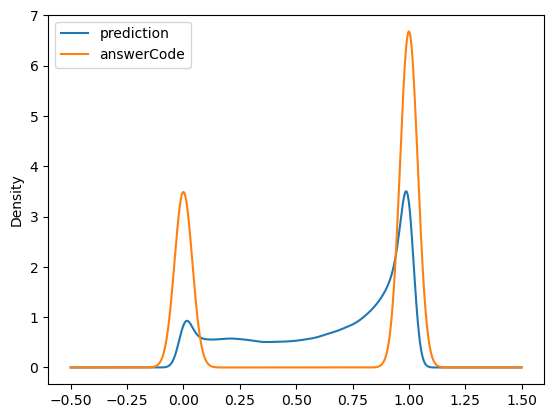

In [329]:
## 예측한거
q = pd.Series(all_preds, name='prediction').plot(kind='kde', legend=True)
## 정답
q = test_df.answerCode.plot(kind='kde', legend=True)

### 정답에서 제출 auc 8156 나온것과 7641 나온것 비교

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

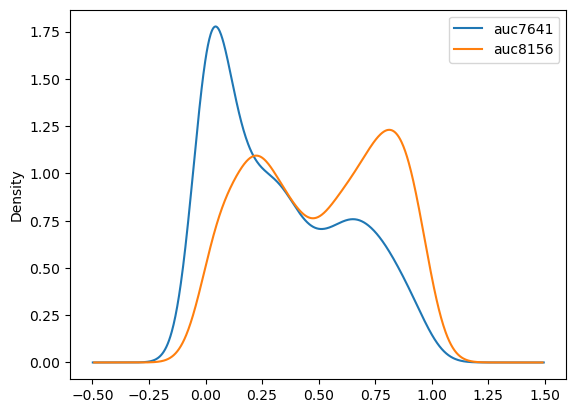

In [187]:
# 제출 AUC 7641 나온 결과
# test_preds = model8.predict(test[test.userID != test.userID.shift(-1)][FEATS])
pred7641 = pd.read_csv('output/12_04_Sun_LGBM_rolling10_mean_acc_train_valid_valid_test로_나누기_피처_29개.csv')
pred7641.rename(columns={'prediction':'auc7641'}).auc7641.plot(kind='kde', legend=True)
# 제출 AUC 8156 나온 결과
pred8156 = pd.read_csv('output/12_03_Sat_LGBM_rolling3_mean_acc_추가_피처_28개.csv')
pred8156.rename(columns={'prediction':'auc8156'}).auc8156.plot(kind='kde', legend=True)

In [330]:
pred8156

,id,prediction,prediction2
0,0,0.698741,1
1,1,0.804103,1
2,2,0.271375,0
3,3,0.856870,1
4,4,0.342280,0
5,5,0.930207,1
6,6,0.108946,0
7,7,0.131264,0
8,8,0.172877,0
9,9,0.939404,1


### 마지막에서 2번째 예측과 정답 비교

0.8983855511583506

<AxesSubplot:ylabel='Density'>

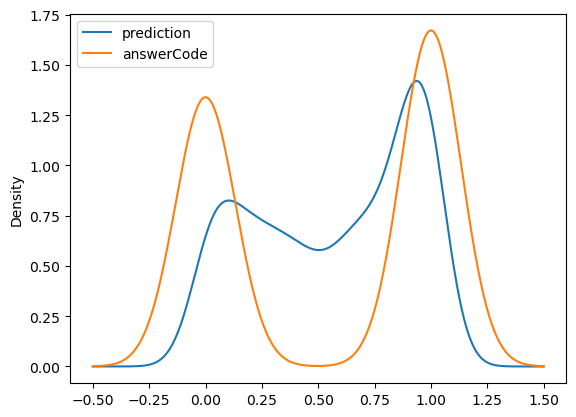

In [121]:
last2_preds = model8.predict(test_df[test_df.userID != test_df.userID.shift(-1)].drop('answerCode',axis=1)[FEATS])
roc_auc_score(test_df[test_df.userID != test_df.userID.shift(-1)][['answerCode']], last2_preds)
# auc 8983의 예측 결과
q = pd.Series(last2_preds, name='prediction').plot(kind='kde', legend=True)
# 정답
test_df[test_df.userID != test_df.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

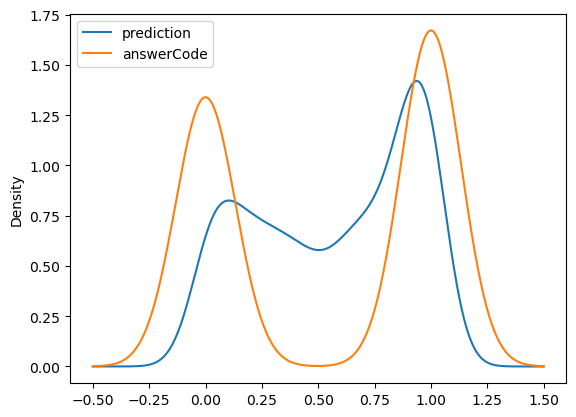

In [192]:
pd.Series(last2_preds, name='prediction').plot(kind='kde', legend=True)
test_df[test_df.userID != test_df.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

In [285]:
last2_df = pd.DataFrame([range(744),last2_preds],).T
last2_df.columns=['id','pred']
last2_df['id'] = last2_df['id'].astype(int)

1034      0
1704      1
3020      1
4279      1
4665      0
         ..
259312    0
259326    1
259340    0
259354    0
259369    1
Name: answerCode, Length: 744, dtype: int64

In [293]:
last2_df['answer']=list(test_df[test_df.userID != test_df.userID.shift(-1)].answerCode)

In [298]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [315]:
last2_df[last2_df.pred>0.97].answer.value_counts()

1    127
Name: answer, dtype: int64

In [320]:
last2_df[last2_df.pred<0.06].answer.value_counts()

0    78
Name: answer, dtype: int64

In [323]:
sum(last2_df[last2_df.pred<0.06].pred)

1.336858140085274

0.8983855511583506

0.8983855511583506

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

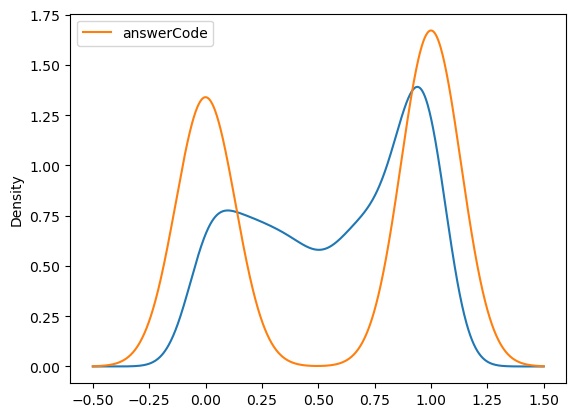

In [324]:
chg_last2_preds = np.where(last2_preds>0.97,1,last2_preds)
chg_last3_preds = np.where(chg_last2_preds<0.06,0,chg_last2_preds)
roc_auc_score(test_df[test_df.userID != test_df.userID.shift(-1)][['answerCode']], last2_preds)
roc_auc_score(test_df[test_df.userID != test_df.userID.shift(-1)][['answerCode']], chg_last3_preds)
pd.Series(chg_last3_preds).plot(kind='kde')
test_df[test_df.userID != test_df.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

### 마지막에서 3번째 예측과 정답 비교

In [96]:
# test 셋에서 문제 제일 적게푼 경우 -> 최소 14번 품
min(test_df.groupby('userID').answerCode.count())

14

In [156]:
roc_auc_score(test_df[test_df.userID != test_df.userID.shift(-1)][['answerCode']], test_df3[test_df3.userID != test_df3.userID.shift(-1)][['answerCode']])

0.6595904991112119

0.8983449747621896

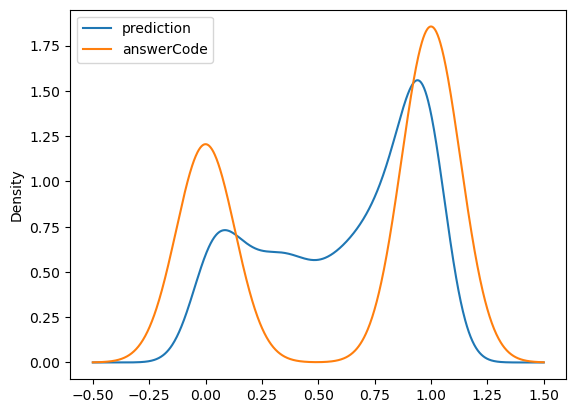

In [139]:
test_df3 = test_df[test_df.userID == test_df.userID.shift(-1)]
last3_preds = model8.predict(test_df3[test_df3.userID != test_df3.userID.shift(-1)].drop('answerCode',axis=1)[FEATS])
roc_auc_score(test_df3[test_df3.userID != test_df3.userID.shift(-1)][['answerCode']], last3_preds)
# auc 8983의 예측 결과
q = pd.Series(last3_preds, name='prediction').plot(kind='kde', legend=True)
## 정답
q = test_df3[test_df3.userID != test_df3.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

### 마지막에서 4번째

prediction AUC Score: 0.8915066740519413


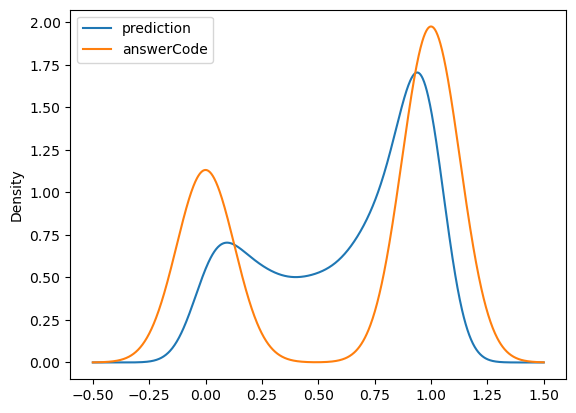

In [138]:
test_df4 = test_df3[test_df3.userID == test_df3.userID.shift(-1)]
last4_preds = model8.predict(test_df4[test_df4.userID != test_df4.userID.shift(-1)].drop('answerCode',axis=1)[FEATS])
last4_auc = roc_auc_score(test_df4[test_df4.userID != test_df4.userID.shift(-1)][['answerCode']], last4_preds)
print(f"prediction AUC Score: {last4_auc}")
# 예측 결과
q = pd.Series(last4_preds, name='prediction').plot(kind='kde', legend=True)

## 정답
q = test_df4[test_df4.userID != test_df4.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

### 마지막에서 5번째

prediction AUC Score: 0.9033076618475389


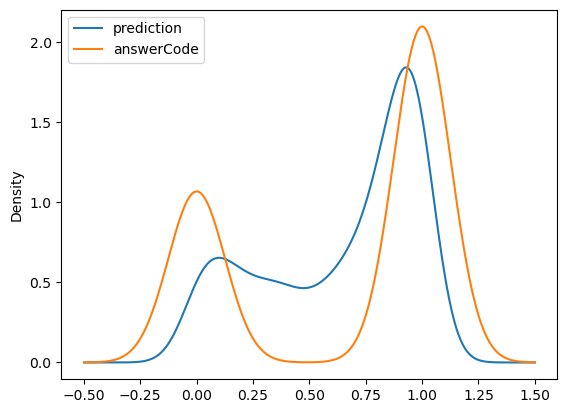

In [140]:
test_df5 = test_df4[test_df4.userID == test_df4.userID.shift(-1)]
last5_preds = model8.predict(test_df5[test_df5.userID != test_df5.userID.shift(-1)].drop('answerCode',axis=1)[FEATS])
last5_auc = roc_auc_score(test_df5[test_df5.userID != test_df5.userID.shift(-1)][['answerCode']], last5_preds)
print(f"prediction AUC Score: {last5_auc}")
# 예측 결과
q = pd.Series(last5_preds, name='prediction').plot(kind='kde', legend=True)

## 정답
q = test_df5[test_df5.userID != test_df5.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

### 마지막에서 6번째

prediction AUC Score: 0.8939967105263158


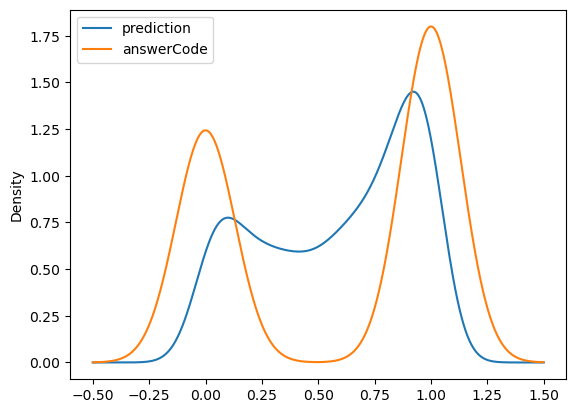

In [141]:
test_df6 = test_df5[test_df5.userID == test_df5.userID.shift(-1)]
last6_preds = model8.predict(test_df6[test_df6.userID != test_df6.userID.shift(-1)].drop('answerCode',axis=1)[FEATS])
last6_auc = roc_auc_score(test_df6[test_df6.userID != test_df6.userID.shift(-1)][['answerCode']], last6_preds)
print(f"prediction AUC Score: {last6_auc}")
# 예측 결과
q = pd.Series(last6_preds, name='prediction').plot(kind='kde', legend=True)

## 정답
q = test_df6[test_df6.userID != test_df6.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

### 마지막에서 7번째

prediction AUC Score: 0.8948437488023424


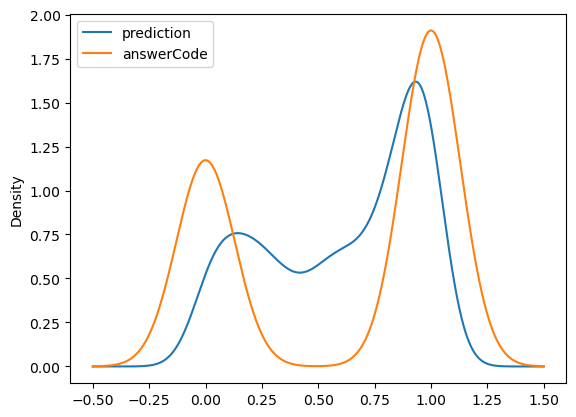

In [142]:
test_df7 = test_df6[test_df6.userID == test_df6.userID.shift(-1)]
last7_preds = model8.predict(test_df7[test_df7.userID != test_df7.userID.shift(-1)].drop('answerCode',axis=1)[FEATS])
last7_auc = roc_auc_score(test_df7[test_df7.userID != test_df7.userID.shift(-1)][['answerCode']], last7_preds)
print(f"prediction AUC Score: {last7_auc}")
# 예측 결과
q = pd.Series(last7_preds, name='prediction').plot(kind='kde', legend=True)

## 정답
q = test_df7[test_df7.userID != test_df7.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

### 마지막에서 8번째

prediction AUC Score: 0.8948437488023424


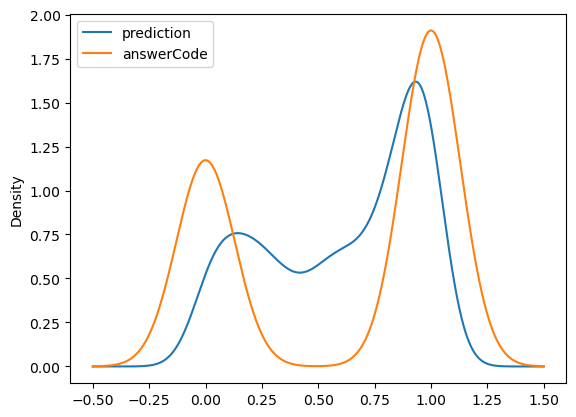

In [143]:
test_df8 = test_df6[test_df6.userID == test_df6.userID.shift(-1)]
last8_preds = model8.predict(test_df8[test_df8.userID != test_df8.userID.shift(-1)].drop('answerCode',axis=1)[FEATS])
last8_auc = roc_auc_score(test_df8[test_df8.userID != test_df8.userID.shift(-1)][['answerCode']], last8_preds)
print(f"prediction AUC Score: {last8_auc}")
# 예측 결과
q = pd.Series(last8_preds, name='prediction').plot(kind='kde', legend=True)

## 정답
q = test_df8[test_df8.userID != test_df8.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

### 마지막에서 9번째

prediction AUC Score: 0.8947423986486486


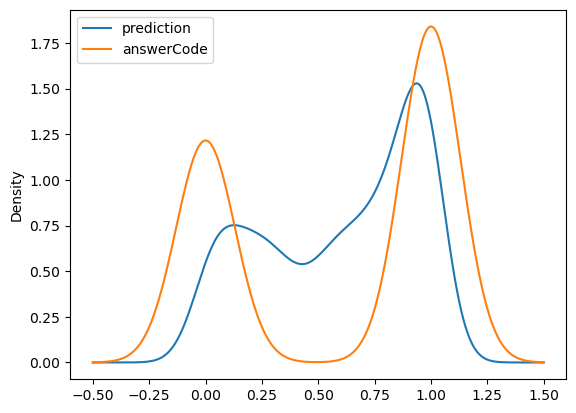

In [144]:
test_df9 = test_df8[test_df8.userID == test_df8.userID.shift(-1)]
last9_preds = model8.predict(test_df9[test_df9.userID != test_df9.userID.shift(-1)].drop('answerCode',axis=1)[FEATS])
last9_auc = roc_auc_score(test_df9[test_df9.userID != test_df9.userID.shift(-1)][['answerCode']], last9_preds)
print(f"prediction AUC Score: {last9_auc}")
# 예측 결과
q = pd.Series(last9_preds, name='prediction').plot(kind='kde', legend=True)

## 정답
q = test_df9[test_df9.userID != test_df9.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

### 마지막에서 10번째

prediction AUC Score: 0.8962241712501858


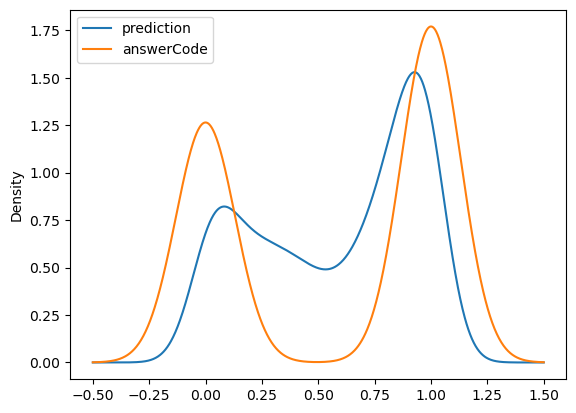

In [145]:
test_df10 = test_df9[test_df9.userID == test_df9.userID.shift(-1)]
last10_preds = model8.predict(test_df10[test_df10.userID != test_df10.userID.shift(-1)].drop('answerCode',axis=1)[FEATS])
last10_auc = roc_auc_score(test_df10[test_df10.userID != test_df10.userID.shift(-1)][['answerCode']], last10_preds)
print(f"prediction AUC Score: {last10_auc}")
# 예측 결과
q = pd.Series(last10_preds, name='prediction').plot(kind='kde', legend=True)

## 정답
q = test_df10[test_df10.userID != test_df10.userID.shift(-1)].answerCode.plot(kind='kde', legend=True)

## 과적합에 영향 줄만한 피처 제거

In [53]:
## 
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
#     "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'rolling10_mean_acc'
        ]

cat_feats = ['uidIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM valset2test assIdx 제거] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train2[FEATS], y_train2)
lgb_x_valid = lgb.Dataset(x_valid2[FEATS], y_valid2)

with mlflow.start_run(run_name=title, description=desc) as run:
    model8 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )

    preds = model8.predict(x_valid2[FEATS])
    acc = accuracy_score(y_valid2, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid2, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model8_run_id=run.info.run_id
    post_slack("done")
    print(f"{model8_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model8, FEATS, f'{file_name}.csv')

([0, 1, 2, 5, 6, 7, 8, 10, 20, 22],
 '🌈(12/03 Sat)[LGBM valset2test assIdx 제거] 피처: 28개',
 '사용된 피처(28)\nuidIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, rolling10_mean_acc')

[LightGBM] [Info] Number of positive: 1483205, number of negative: 783381
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11807
[LightGBM] [Info] Number of data points in the train set: 2266586, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654378 -> initscore=0.638341
[LightGBM] [Info] Start training from score 0.638341
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.433367
[200]	valid_0's binary_logloss: 0.425486
[300]	valid_0's binary_logloss: 0.420669
[400]	valid_0's binary_logloss: 0.415935
[500]	valid_0's binary_logloss: 0.411976
[600]	valid_0's binary_logloss: 0.409177
[700]	valid_0's binary_logloss: 0.407226
[800]	valid_0's binary_logloss: 0.405359
[900]	valid_0's binary_logloss: 0.40457
[1000

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.7649
run_id = '59025bf22784476f80412cac8c3356b5'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

### Feature Importance 시각화

In [15]:
import eli5
eli5.show_weights(model7)

Weight,Feature
0.3456,big_category_user_cum_acc
0.2573,assIdx
0.0946,time_category
0.0807,uidIdx
0.0587,testIdx
0.0411,KnowledgeTag
0.0248,test_mean
0.0225,solvesec_3600
0.0205,problem_num
0.0186,test_std


In [1]:
import shap
shap.initjs()
valid_explainer = shap.TreeExplainer(model7)
valid_shap_values = valid_explainer.shap_values(x_valid[FEATS])
shap.force_plot(valid_explainer.expected_value[1], valid_shap_values[1][:,:], x_valid[FEATS].iloc[:,:])

test_explainer = shap.TreeExplainer(model7)
test_shap_values = test_explainer.shap_values(test[test.userID != test.userID.shift(-1)][FEATS])
shap.force_plot(test_explainer.expected_value[1], test_shap_values[1][:,:],  test[FEATS].iloc[:,:])

NameError: name 'model7' is not defined

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=
run_id = model7_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()